import modules

In [ ]:
import platform
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

if platform.system() == "Darwin":           # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')

load raw_data

In [ ]:
raw_data = pd.read_csv("./raw_data.csv", encoding='euc-kr')

EDA

In [ ]:
raw_data

In [ ]:
raw_data.info()

In [11]:
raw_data.isnull().sum()

날짜         0
위안화원_시     0
유로달러_시     0
코스피시가      0
유로인덱스_시    0
달러엔_시      0
달러위안화_시    0
달러원종가      0
달러원시가      0
CD91       0
WTI        0
달러인덱스      0
콜금리        0
BIR        0
엔원_시       0
dtype: int64

X : features, y : label

In [ ]:
df = raw_data.copy()
df.drop(['날짜'],axis=1,inplace=True)
X = df.drop('달러원종가',axis=1) # features
y = df[['달러원종가']] # target label

VIF for feature selection

In [12]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import statsmodels.api as sm

feature_add = sm.add_constant(X, has_constant='add')

# sm OLS 적합
model = sm.OLS(y , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  달러원종가   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 3.806e+04
Date:                Sat, 11 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:36:43   Log-Likelihood:                -10762.
No. Observations:                3318   AIC:                         2.155e+04
Df Residuals:                    3305   BIC:                         2.163e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9622     17.038     -0.526      0.599     -42.369      24.444
위안화원_시        -0.1057      0.060     -1.754      0.080      -0.224       0.012
유로달러_시         7.4949      3.608      2.077      0.038       0.421      14.569
코스피시가         -0.0014      0.001     -2.042      0.041      -0.003   -5.56e-05
유로인덱스_시        0.1106      0.045      2.446      0.015       0.022       0.199
달러엔_시          0.1106      0.045      2.446      0.015       0.022       0.199
달러위안화_시       -4.1054      1.735     -2.367      0.018      -7.506      -0.704
달러원시가          0.9838      0.013     78.648      0.000       0.959       1.008
CD91          -0.5471      0.943     -0.580      0.562      -2.396       1.302
WTI            0.0120      0.012      0.969      0.332      -0.012       0.036
달러인덱스          0.1808      0.052      3.477      0.001       0.079       0.283
콜금리            0.5049      0.856      0.590      0.555      -1.173       2.183
BIR            0.2120      0.759      0.279      0.780      -1.276       1.700
엔원_시           2.1068      0.781      2.698      0.007       0.576       3.638
==============================================================================
Omnibus:                      202.786   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              889.101
Skew:                           0.036   Prob(JB):                    8.59e-194
Kurtosis:                       5.535   Cond. No.                     4.74e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.29e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
df = raw_data.copy()
df.drop(['날짜','CD91','달러원시가'],axis=1,inplace=True)
X = df.drop('달러원종가',axis=1)
y= df[['달러원종가']]

<Axes: >

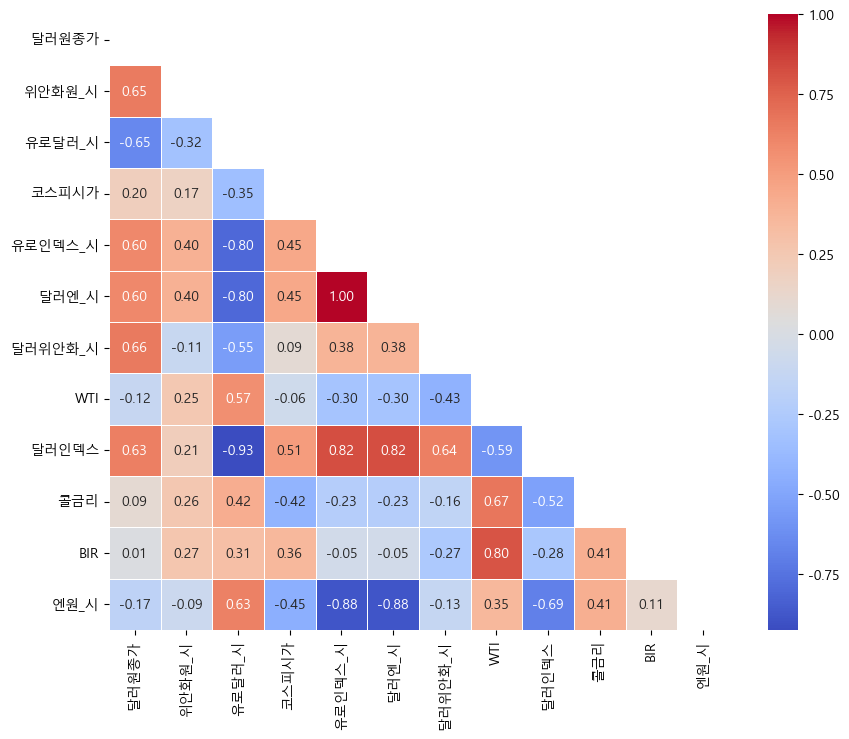

In [14]:
# 변수에 따라서 다중공정성없애기 
# 다중공정성으로 유로달러, 유로인덱스 제외 
corr_data = df[[ '달러원종가',  '위안화원_시', '유로달러_시', '코스피시가', '유로인덱스_시', '달러엔_시',
       '달러위안화_시',  'WTI', '달러인덱스', '콜금리', 'BIR', '엔원_시']].corr()
plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_data, dtype=bool))

sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f', mask=mask)



In [15]:
X.drop(['유로달러_시','유로인덱스_시'],axis=1,inplace=True)

<Axes: >

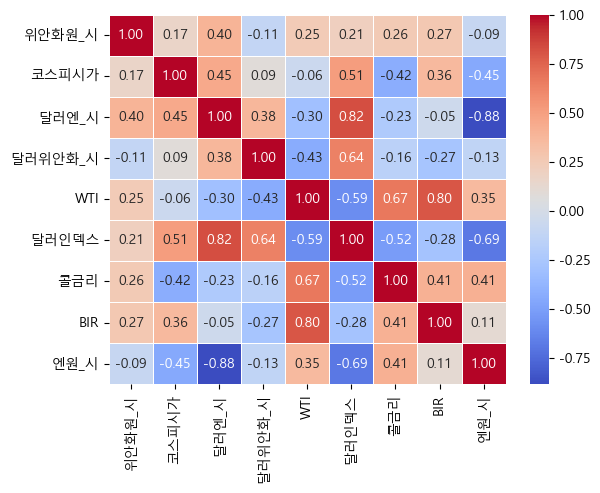

In [16]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')

In [ ]:
X.drop(['달러엔_시','달러인덱스'],axis=1,inplace=True)

In [ ]:
# 종속변수 인과관계 확인하기 
correlation = np.abs(X.corrwith(df['달러원종가'])).sort_values(ascending=False)
correlation

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# statsmodels의 상수항을 추가하기 위해 X에 상수 열 추가
X = sm.add_constant(X)

# VIF 계산
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# VIF 결과 출력
print(vif)

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd


feature_add = sm.add_constant(raw_data, has_constant='add')

# sm OLS 적합
model = sm.OLS(y , feature_add)
fitted_model = model.fit()

# summary 함수통해 결과출력
fitted_model.summary()

In [ ]:
X.drop(['WTI'] ,axis=1,inplace=True)

In [ ]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')

## Train Test split 

In [ ]:
from sklearn.model_selection import cross_val_score, KFold


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42, shuffle=False)

pipeline = Pipeline([
    ('scaler',MinMaxScaler()),
    ('lr', LinearRegression())
	])
scores = cross_val_score(pipeline,X_train , y_train ,scoring='neg_mean_squared_error' ,  cv=5 )

scores.mean()

In [ ]:

# 다양한 테스트 세트 크기를 시도하기 위한 비율 리스트
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8]

# 교차 검증 설정
n_splits = 5  # 폴드(Fold)의 수 
random_state = 42  # 시드(seed) 값 (재현성을 위해 사용)

# 모델 및 스케일러 초기화 
regressor = LinearRegression()
scaler = MinMaxScaler()
pipeline = Pipeline([
    ('scaler', scaler),
    ('regressor', regressor)
])

# 다양한 테스트 세트 크기에 대한 결과 저장
results = {}

for test_size in test_sizes:
    # 테스트 세트 크기 설정
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    # 교차 검증 수행 및 성능 평가 
    scores = cross_val_score(pipeline, X_train, y_train, cv=KFold(n_splits=n_splits, shuffle=True, random_state=random_state), scoring='neg_mean_squared_error')
    
    # 평균 제곱 오차의 평균값 저장
    mean_mse = -scores.mean()
    
    # 결과 저장
    results[test_size] = mean_mse

# 결과 출력
for test_size, mse in results.items():
    print(f"Test Size: {test_size}, Mean Squared Error: {mse:.2f}")

In [ ]:
#  교차검증 + GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8]

# 교차 검증 설정
n_splits_1 = 5  # 폴드(Fold)의 수 (사용자에게 맞게 변경 가능)
random_state_1 = 42  # 시드(seed) 값 (재현성을 위해 사용)

# 모델 및 스케일러 초기화 (사용자가 원하는 모델 및 스케일러로 변경 가능)
GB = GradientBoostingRegressor()
scaler = MinMaxScaler()
pipeline = Pipeline([
    ('scaler', scaler),
    ('GB', GB)
])

# 다양한 테스트 세트 크기에 대한 결과 저장
results = {}

for test_size in test_sizes:
    # 테스트 세트 크기 설정

 

    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # 교차 검증 수행 및 성능 평가 (이 예제에서는 평균 제곱 오차를 사용)
    scores_1 = cross_val_score(pipeline, X_train, y_train, 
                            cv=KFold(n_splits=n_splits_1, shuffle=True,
                             random_state=random_state_1), 
                             scoring='neg_mean_squared_error')
    
    # 평균 제곱 오차의 평균값 저장
    mean_mse = -scores_1.mean()
    
    # 결과 저장
    results[test_size] = mean_mse

# 결과 출력
for test_size, mse in results.items():
    print(f"Test Size: {test_size}, Mean Squared Error: {mse:.4f}")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"전체 데이터 수 = {X.shape[0]}")
print(f'train set 데이터 수 = {X_train.shape[0]}')
print(f'test set 데이터 수 = {X_test.shape[0]}')

## 스켈링 (Min & Std + LR 비교)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

StdardScaler = MinMaxScaler()
X_train_std = StdardScaler.fit_transform(X_train)
X_test_std = StdardScaler.transform(X_test)

In [ ]:
# 스켈링된 데이터 분포 그래프로 보기 

## Feature Selection RFE, Filter, Embeded

In [ ]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression

# scikit-learn과 statsmodels 서로 호환되지 않을 수 있습니다.  
model = LinearRegression()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False,random_state=42)

S_RFE = RFE(model, n_features_to_select=5)
X_train_RFE = S_RFE.fit_transform(X_train,y_train)
X_test_RFE = S_RFE.transform(X_test)
X_train_RFE


In [ ]:
S_RFE.feature_names_in_
S_RFE.ranking_
S_RFE.feature_names_in_[S_RFE.ranking_ ==1]   

In [ ]:
## Filter 
from sklearn.feature_selection import f_regression, SelectKBest
## selctor 정의하기.
selector = SelectKBest(score_func=f_regression, k=5)
## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)
## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

selector.feature_names_in_

selector.get_support()


selected_mask =selector.get_support()
selected_names = X.columns[selected_mask]
unselected_names = X.columns[~selected_mask]

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

In [ ]:
## Embedded
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=RandomForestRegressor(), threshold=0.1).fit(X_train, y_train)
rf = selector.get_support()
count = np.count_nonzero(rf)
count

selector.get_support()

selected_mask2=selector.get_support()

selected_names = X.columns[selected_mask2]
unselected_names = X.columns[~selected_mask2]

print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

## 선형회귀 

In [ ]:
# 스케일링 + 선형회귀 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
df = raw_data.copy()



In [ ]:

X_1=df[['위안화원_시', '코스피시가', '달러위안화_시', '콜금리', '엔원_시','BIR']]
y_1=df['달러원종가']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

pipeline_1 = Pipeline([
    ('scaler', MinMaxScaler()),  # Min-Max scaler
    ('regressor', LinearRegression())  # Linear regression model
])

pipeline_1.fit(X_train_1,y_train_1)
y_pred_1=pipeline_1.predict(X_test_1)

coefficients = pipeline_1['regressor'].coef_

intercept = pipeline_1['regressor'].intercept_
mse= mean_squared_error(y_test_1,y_pred_1)
rmse=np.sqrt(mse)

print(f"MSE : {mse:.3f}, RMSE:{rmse:.3f}")
print(f"Variance score:{r2_score(y_test_1,y_pred_1):.3f}")
print("Coefficients (Weights):", coefficients)
print("Intercept (Bias):", intercept)

In [ ]:
# coef=pd.Series(data=np.round(coefficients,2), index=X.columns)
# coef
# 왜 부호가 맞지 않을까? 
selected_features = X_1.columns
coef = pd.Series(data=np.round(pipeline_1['regressor'].coef_, 2), index=selected_features)
coef

In [ ]:
result = pd.DataFrame(data={'Y':y_test_1, 'Y_pred(LR)':y_pred_1,'diff(LR)':np.round(np.abs(y_test_1-y_pred_1),2)})
result.sort_values(by=['diff(LR)'], ascending=False)

In [ ]:
df_2 = df.copy() 
X = df_2[['위안화원_시', '코스피시가', '달러위안화_시', '콜금리', '엔원_시']]  ## 그렇게 해야지 ()이 부분 없어도 오류 안남
y=df_2['달러원종가']                                                                             ## y가 데이터프레임 전체로 저장되서 shape오류가 났었음
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 의사결정나무 기반 회귀 알고리즘 

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
lgb_model = LGBMRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

def printRegressorResult(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((np.array(y_test) - np.array(y_pred)) / np.array(y_test))) * 100
    print('MSE: {0:.3f}, RMSE: {1:.3f}, R-squared: {2:.3f}, MAE: {3:.3f}, MAPE: {4:.3f}%'.format(mse, rmse, r2, mae, mape))


In [ ]:

model_list = [forest_model, lgb_model, xgb_model]
    

for model in model_list:
    model.fit(X_train, y_train)  # 모델 학습
    y_preds = model.predict(X_test)
    print('{0}모델'.format(model.__class__.__name__))
    printRegressorResult(y_test, y_preds)

In [ ]:
from sklearn.linear_model import SGDRegressor

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Min-Max scaler
    ('sgd', SGDRegressor(shuffle=False))  # SGDRegressor model
])

pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)


mse= mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((np.array(y_test) - np.array(y_pred)) / np.array(y_test))) * 100
print('MSE: {0:3f}, RMSE: {1:3f}, R-squared: {2:3f}, MAE: {3:3f}, MAPE: {4:3f}%'.format(mse, rmse, r2, mae, mape))


In [ ]:

result = pd.DataFrame(data={'Y':y_test, 'Y_pred(SGD)':y_pred,'diff(SGD)':np.round(np.abs(y_test-y_pred),2)})
result.sort_values(by=['diff(SGD)'], ascending=False)

In [ ]:
from scipy.stats import normaltest
import statsmodels.api as sm
# Residuals
residuals = result['diff(SGD)']

# Residual analysis


# Q-Q Plot
sm.qqplot(residuals.values.flatten(), line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# 잔차의 정규성 검정
statistic, p_value = normaltest(residuals.values.flatten())

print("Normality test statistic:", statistic)
print("p-value:", p_value)

In [ ]:
# from scipy.stats import jarque_bera
import numpy as np
from scipy.stats import jarque_bera


# Jarque-Bera 정규성 검정 수행
jb_value, p_value = jarque_bera(residuals)

# 검정 통계량과 p-value 출력 
print("Jarque-Bera 검정 통계량: {:.2f}".format(jb_value))
print("p-value: {:.8f}".format(p_value))

In [ ]:
import seaborn as sns

sns.residplot(x=result['Y'],y= result['Y_pred(SGD)'])
plt.show()

In [ ]:
np.mean(residuals)

### Grid Search CV 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE



sclaer = MinMaxScaler()
lgb=LGBMRegressor()
feature = RFE(LinearRegression(), n_features_to_select=5)

pipe = Pipeline([
    ('scaler',sclaer),
    ('feature_select',feature),
    ('model', lgb)
])

param = {
    'model__max_depth': [2,3,5],
    'model__learning_rate' : [0.1,0.01]
}

grid = GridSearchCV(estimator=pipe, param_grid=param, cv=3)
grid.fit(X_train,y_train)

In [ ]:
grid.best_params_

In [ ]:
y_pred=grid.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
score = r2_score(y_pred,y_test)


print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r2_score:{score:.2f}')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sclaer = MinMaxScaler()
RF = RandomForestRegressor()
feature = RFE(LinearRegression(), n_features_to_select=5)

pipe = Pipeline([
    ('scaler', sclaer),
    ('feature_select', feature),
    ('model', RF)  # Changed 'rf' to 'RF'
])

param = {
    'model__max_depth': [2, 3, 5],
    'model__min_samples_leaf': [10, 20, 30],  # Corrected the parameter name
    'model__n_estimators': [100, 200, 300]
}

grid = GridSearchCV(estimator=pipe, param_grid=param, cv=3)
grid.fit(X_train, y_train)


In [ ]:
grid.best_params_

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
score = r2_score(y_pred,y_test)


print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r2_score:{score:.2f}')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sclaer = MinMaxScaler()
XGB = XGBRegressor()
feature = RFE(LinearRegression(), n_features_to_select=5)

pipe = Pipeline([
    ('scaler', sclaer),
    ('feature_select', feature),
    ('model', XGB)  # Changed 'rf' to 'RF'
])

param = {
    'model__max_depth': [2, 3, 5],
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate' : [0.1,0.01]
}

grid = GridSearchCV(estimator=pipe, param_grid=param, cv=3)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

In [ ]:

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
score = r2_score(y_pred,y_test)


print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r2_score:{score:.2f}')